# 1. Trigger Finding
## 1.1. Trigger reconstruction

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

#### Setup the Model Architecture

In [29]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(32 * 4 * 4, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 10),
            nn.Softmax(dim=-1)
        )
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 32 * 4 * 4)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


#### Load the Poisoned Model

In [30]:
model = ConvNet()
model.load_state_dict(torch.load("/kaggle/input/hw4/pytorch/1/1/poisened_model_8.pth"))
model.eval()  # Set the model to evaluation mode


ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

### For one class
#### Define the Trigger Optimization Procedure

In [39]:
# Define the pattern and mask
pattern = torch.nn.Parameter(torch.ones(1, 1, 28, 28))  # Assuming input size is 28x28
mask = torch.nn.Parameter(torch.ones(1, 1, 28, 28))

# Optimizer
optimizer = optim.Adam([pattern, mask], lr=0.01)

# Define the loss criterion
criterion = nn.CrossEntropyLoss()

# Optimization loop
for epoch in range(100):
    optimizer.zero_grad()
    pattern_t = torch.sigmoid(pattern)
    mask_t = torch.sigmoid(mask)
    # Create a poisoned image example
    x = pattern_t * mask_t
    # Forward pass
    outputs = model(x)
    label = torch.tensor([8])  # Target class index
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 1.5473836660385132
Epoch 10, Loss: 1.4724997282028198
Epoch 20, Loss: 1.4645735025405884
Epoch 30, Loss: 1.462934970855713
Epoch 40, Loss: 1.4623823165893555
Epoch 50, Loss: 1.4621285200119019
Epoch 60, Loss: 1.461980938911438
Epoch 70, Loss: 1.461879849433899
Epoch 80, Loss: 1.4618017673492432
Epoch 90, Loss: 1.4617377519607544


#### Visualize the Trigger

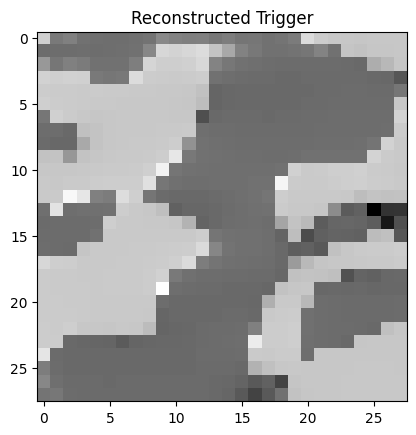

In [40]:
pattern_np = torch.sigmoid(pattern).detach().numpy().squeeze()
mask_np = torch.sigmoid(mask).detach().numpy().squeeze()

plt.imshow(pattern_np * mask_np, cmap='gray')
plt.title('Reconstructed Trigger')
plt.show()


### For all classes

Class 0, Epoch 0, Loss: 2.446845293045044
Class 0, Epoch 10, Loss: 2.412449836730957
Class 0, Epoch 20, Loss: 2.4079225063323975
Class 0, Epoch 30, Loss: 2.398113489151001
Class 0, Epoch 40, Loss: 2.373093605041504
Class 0, Epoch 50, Loss: 2.2750697135925293
Class 0, Epoch 60, Loss: 1.987655758857727
Class 0, Epoch 70, Loss: 1.7070319652557373
Class 0, Epoch 80, Loss: 1.5865319967269897
Class 0, Epoch 90, Loss: 1.5408320426940918
Class 1, Epoch 0, Loss: 2.3999907970428467
Class 1, Epoch 10, Loss: 2.041295289993286
Class 1, Epoch 20, Loss: 1.647334337234497
Class 1, Epoch 30, Loss: 1.5350900888442993
Class 1, Epoch 40, Loss: 1.5005886554718018
Class 1, Epoch 50, Loss: 1.487339973449707
Class 1, Epoch 60, Loss: 1.4809963703155518
Class 1, Epoch 70, Loss: 1.4775183200836182
Class 1, Epoch 80, Loss: 1.475259780883789
Class 1, Epoch 90, Loss: 1.4736415147781372
Class 2, Epoch 0, Loss: 2.4451656341552734
Class 2, Epoch 10, Loss: 2.4074251651763916
Class 2, Epoch 20, Loss: 2.4005274772644043


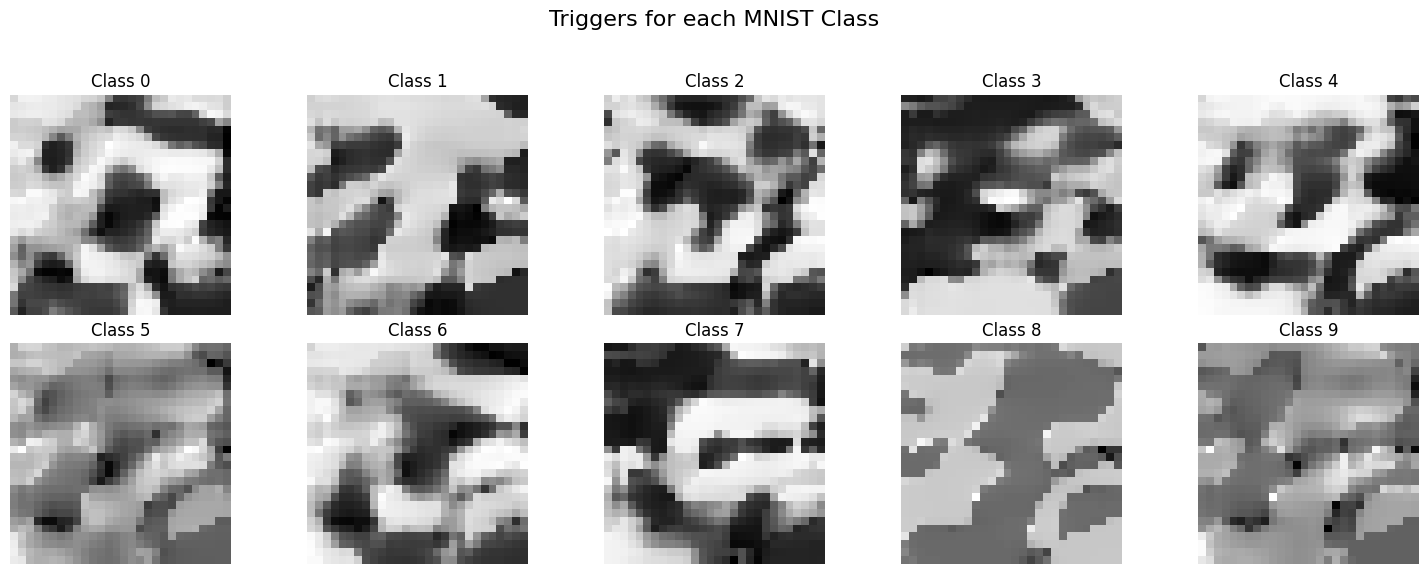

In [38]:
# Visualize triggers for each class
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Triggers for each MNIST Class', fontsize=16)

for target_class in range(10):  # Iterate over each class from 0 to 9
    pattern = torch.nn.Parameter(torch.ones(1, 28, 28))  # Single channel image
    mask = torch.nn.Parameter(torch.ones(1, 28, 28))
    optimizer = optim.Adam([pattern, mask], lr=0.01)

    # Optimization loop
    for epoch in range(100):  # Number of epochs
        optimizer.zero_grad()
        pattern_t = torch.sigmoid(pattern)
        mask_t = torch.sigmoid(mask)
        # Create a poisoned image example, ensure correct dimensions
        x = (pattern_t * mask_t).unsqueeze(0)  # Corrected dimension handling
        # Forward pass
        outputs = model(x)
        label = torch.tensor([target_class])  # Set the target class index
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Class {target_class}, Epoch {epoch}, Loss: {loss.item()}")

    # Visualize the trigger
    pattern_np = pattern_t.detach().numpy().squeeze()
    mask_np = mask_t.detach().numpy().squeeze()
    ax[target_class // 5, target_class % 5].imshow(pattern_np * mask_np, cmap='gray')
    ax[target_class // 5, target_class % 5].set_title(f'Class {target_class}')
    ax[target_class // 5, target_class % 5].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 1.2. Attacked tags

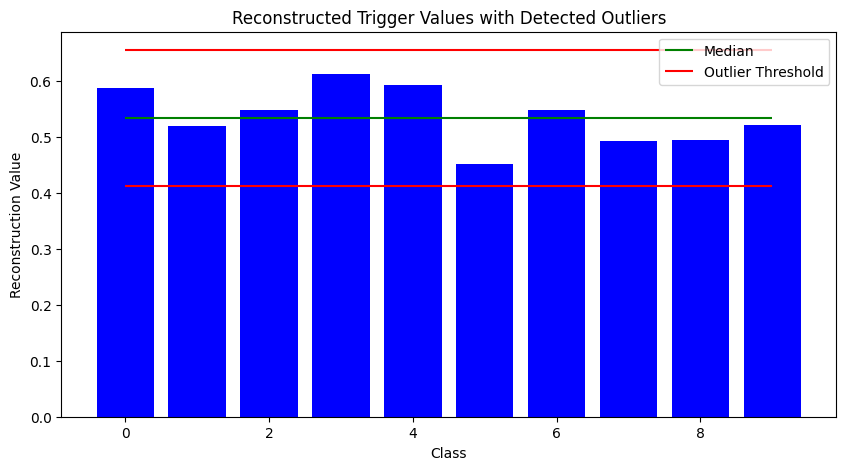

Attacked Classes (Outliers): []


In [60]:
def median_absolute_deviation(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return mad, median

# Simulate reconstruction values for 10 classes
np.random.seed(0)
data = np.random.normal(loc=0.5, scale=0.05, size=10)
# data[2] += 0.5  # Simulate an outlier (attacked class)
# data[7] += 0.4  # Simulate another outlier (attacked class)

# Calculate MAD and identify outliers
mad, median = median_absolute_deviation(data)
threshold = 3 * mad  # Define threshold for outliers

outliers = np.where(np.abs(data - median) > threshold)[0]  # Identify outlier indices

# Plotting the results
plt.figure(figsize=(10, 5))
plt.bar(range(10), data, color='blue')
plt.xlabel('Class')
plt.ylabel('Reconstruction Value')
plt.hlines(median, xmin=0, xmax=9, color='green', label='Median')
plt.hlines([median + threshold, median - threshold], xmin=0, xmax=9, colors='red', label='Outlier Threshold')
plt.legend()
plt.title('Reconstructed Trigger Values with Detected Outliers')
plt.show()

print("Attacked Classes (Outliers):", outliers)
